In [56]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(purrr)
library(visdat)
library(ggplot2)
library(parallel)
library(rstatix)
library(parallel)
library(ggpubr)

In [57]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data_subset<-meta_data %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 2 Day 0'))

In [58]:
CBC<-read.csv('lab_results_BRI.csv')
Samples_selected_scRNA<-meta<-read.csv('count_df_scRNA.csv')%>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 2 Day 0'))

In [59]:
CBC<-CBC[c('sample.sampleKitGuid','absolute_basophil_count',
    'absolute_eosinophil_count_aec',
    'absolute_lymphocyte_count_alc',
    'absolute_monocyte_count_amc',
    'absolute_neutrophil_count_anc')]

In [60]:
CBC<-CBC %>% filter(sample.sampleKitGuid %in% Samples_selected_scRNA$sample.sampleKitGuid)

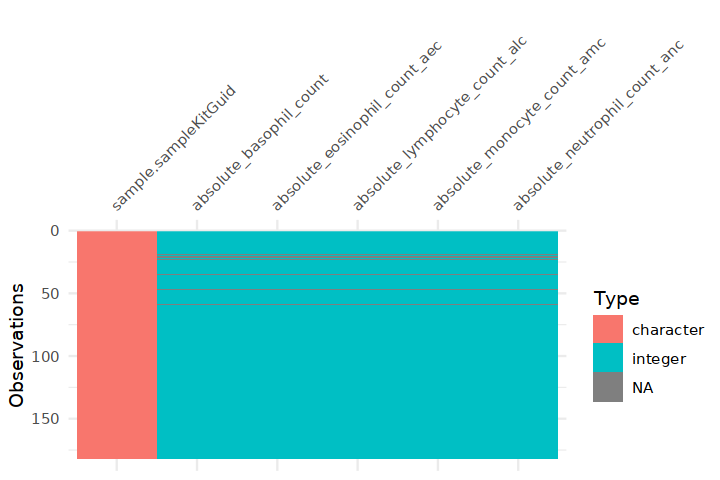

In [61]:
options(repr.plot.width = 6, repr.plot.height = 4)

vis_dat(CBC)

In [75]:
CBC<-CBC[complete.cases(CBC),]

In [108]:
compare_means(absolute_monocyte_count_amc ~ sample.visitName, data = tst)


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
absolute_monocyte_count_amc,Flu Year 1 Day 0,Flu Year 2 Day 0,0.353867,0.35,0.35,ns,Wilcoxon


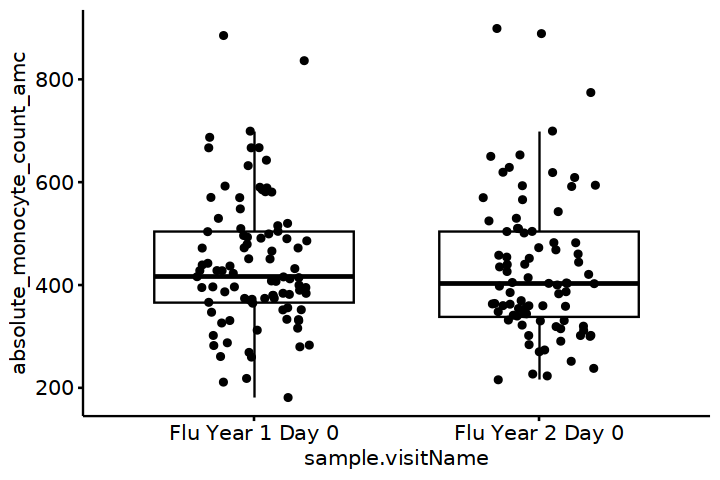

In [107]:
ggboxplot(tst , 
          x = "sample.visitName", 
          y = "absolute_monocyte_count_amc",
          palette = "jco",
          add = "jitter")+compare_means(formula, data, method = "wilcox.test", paired = FALSE,
  group.by = NULL, ref.group = NULL, ...)

In [116]:
tt<-names(table(as.data.frame(tst)$subject.subjectGuid)[table(as.data.frame(tst)$subject.subjectGuid)==2])

In [118]:
tst<-left_join(CBC,unique(meta[c('sample.sampleKitGuid', 'subject.subjectGuid','sample.visitName')]))
donor_id<-tst$subject.subjectGuid[table(tst$subject.subjectGuid)==2]
as.data.frame(tst) %>% filter(subject.subjectGuid %in% tt) %>%
  select(absolute_monocyte_count_amc, subject.subjectGuid,sample.visitName)  %>% arrange(subject.subjectGuid, sample.visitName) %>%
  wilcox_test(absolute_monocyte_count_amc ~ sample.visitName, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 

Joining with `by = join_by(sample.sampleKitGuid)`


.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
absolute_monocyte_count_amc,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,1980,0.386,0.386,ns


In [63]:
B=c('CD27+ effector B cell', 'CD27- effector B cell',
 'Core memory B cell', 'Early memory B cell',
 'Type 2 polarized memory B cell', 'CD95 memory B cell',
 'Activated memory B cell', 'Core naive B cell',
 'ISG+ naive B cell', 'Plasma cell', 'Transitional B cell')
T=c('CD8aa','DN T cell','CD8 MAIT',
 'CD4 MAIT','ISG+ MAIT',
 'CM CD4 T cell','GZMB- CD27+ EM CD4 T cell',
 'GZMB- CD27- EM CD4 T cell','ISG+ memory CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell','GZMK+ CD27+ EM CD8 T cell',
 'CM CD8 T cell','KLRF1- GZMB+ CD27- EM CD8 T cell',
 'GZMK- CD27+ EM CD8 T cell',
 'KLRF1+ GZMB+ CD27- EM CD8 T cell','ISG+ memory CD8 T cell',
'Core naive CD4 T cell','SOX4+ naive CD4 T cell','ISG+ naive CD4 T cell','Core naive CD8 T cell ','SOX4+ naive CD8 T cell','ISG+ naive CD8 T cell',
 'Proliferating T cell','Naive CD4 Treg',
 'Memory CD4 Treg', 'KLRB1+ memory CD4 Treg','Memory CD8 Treg',
 'GZMK+ memory CD4 Treg','KLRB1+ memory CD8 Treg','GZMK+ Vd2 gdT','GZMB+ Vd2 gdT',
 'Naive Vd1 gdT',
 'KLRF1+ effector Vd1 gdT','SOX4+ Vd1 gdT','KLRF1- effector Vd1 gdT')
NK=c('CD56bright NK cell','Adaptive NK cell',
 'GZMK+ CD56dim NK cell','GZMK- CD56dim NK cell',
 'ISG+ CD56dim NK cell','Proliferating NK cell')
ILC=c('ILC')
Monocyte=c('Core CD14 monocyte',
 'ISG+ CD14 monocyte',
 'IL1B+ CD14 monocyte',
 'Core CD16 monocyte',
 'ISG+ CD16 monocyte',
 'C1Q+ CD16 monocyte',
 'Intermediate monocyte')

In [64]:
CBC_to_scRNA_Monocyte=Monocyte
CBC_to_scRNA_Lymphocyte=c(NK,B,T,ILC)

In [42]:
Samples_selected_scRNA<-left_join(Samples_selected_scRNA,CBC)

Joining with `by = join_by(sample.sampleKitGuid)`


In [11]:
abs_counts_df <- Samples_selected_scRNA %>%
  group_by(sample.sampleKitGuid) %>%
  mutate(abs_counts = case_when(
    AIFI_L3 %in% CBC_to_scRNA_Monocyte ~ percentage * absolute_monocyte_count_amc,
    AIFI_L3 %in% CBC_to_scRNA_Lymphocyte ~ percentage * absolute_lymphocyte_count_alc,
    TRUE ~ NA_real_  
  ))%>% ungroup()

In [ ]:
as.data.frame(abs_counts_df) %>% 
  select(abs_counts,AIFI_L3, subject.subjectGuid,sample.visitName) %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid, sample.visitName) %>%
  wilcox_test(absolute_lymphocyte_count_alc ~ sample.visitName, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 

In [13]:
abs_counts_df<-abs_counts_df[!is.na(abs_counts_df$abs_counts),]

In [14]:
abs_counts_df$abs_counts<-as.numeric(round(abs_counts_df$abs_counts))

In [15]:
donor_with_Y1Y2<-names(table(meta_data_subset$subject.subjectGuid)[table(meta_data_subset$subject.subjectGuid)==2])
abs_counts_df<-abs_counts_df %>% filter(subject.subjectGuid %in% donor_with_Y1Y2)

In [16]:
abs_counts_df<-abs_counts_df %>%  
group_by(AIFI_L3,subject.subjectGuid) %>% 
mutate(available_n = n()) %>% 
filter(available_n==2)

In [17]:
STAT_res<-as.data.frame(abs_counts_df) %>% 
  select(abs_counts,AIFI_L3, subject.subjectGuid,sample.visitName) %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid, sample.visitName) %>%
  wilcox_test(abs_counts ~ sample.visitName, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Activated memory B cell,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,59,59,668.0,0.1020,0.4080000,ns
Adaptive NK cell,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,1941.5,0.4870,0.7814634,ns
C1Q+ CD16 monocyte,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2156.0,0.0611,0.3332727,ns
CD27+ effector B cell,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,1925.0,0.5340,0.7814634,ns
CD27- effector B cell,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,1724.0,0.7870,0.8909434,ns
CD4 MAIT,abs_counts,Flu Year 1 Day 0,Flu Year 2 Day 0,77,77,1484.5,0.9130,0.9726316,ns


In [24]:
STAT_res[STAT_res$p.adj<0.05,]

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,max_y
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>


In [18]:
max_y<-abs_counts_df %>%
  select(abs_counts, AIFI_L3, sample.visitName) %>%
  distinct() %>%
  group_by(AIFI_L3) %>%
  dplyr::summarize(max_abs_counts = max(abs_counts)) %>%
  ungroup() %>% arrange(AIFI_L3) %>% select(max_abs_counts) %>% pull()

Adding missing grouping variables: `subject.subjectGuid`


In [19]:
STAT_res<-STAT_res%>% arrange(AIFI_L3)
STAT_res$max_y<-max_y*1.1

In [20]:
STAT_res$p<-round(STAT_res$p,4)
STAT_res$p.adj<-round(STAT_res$p.adj,4)

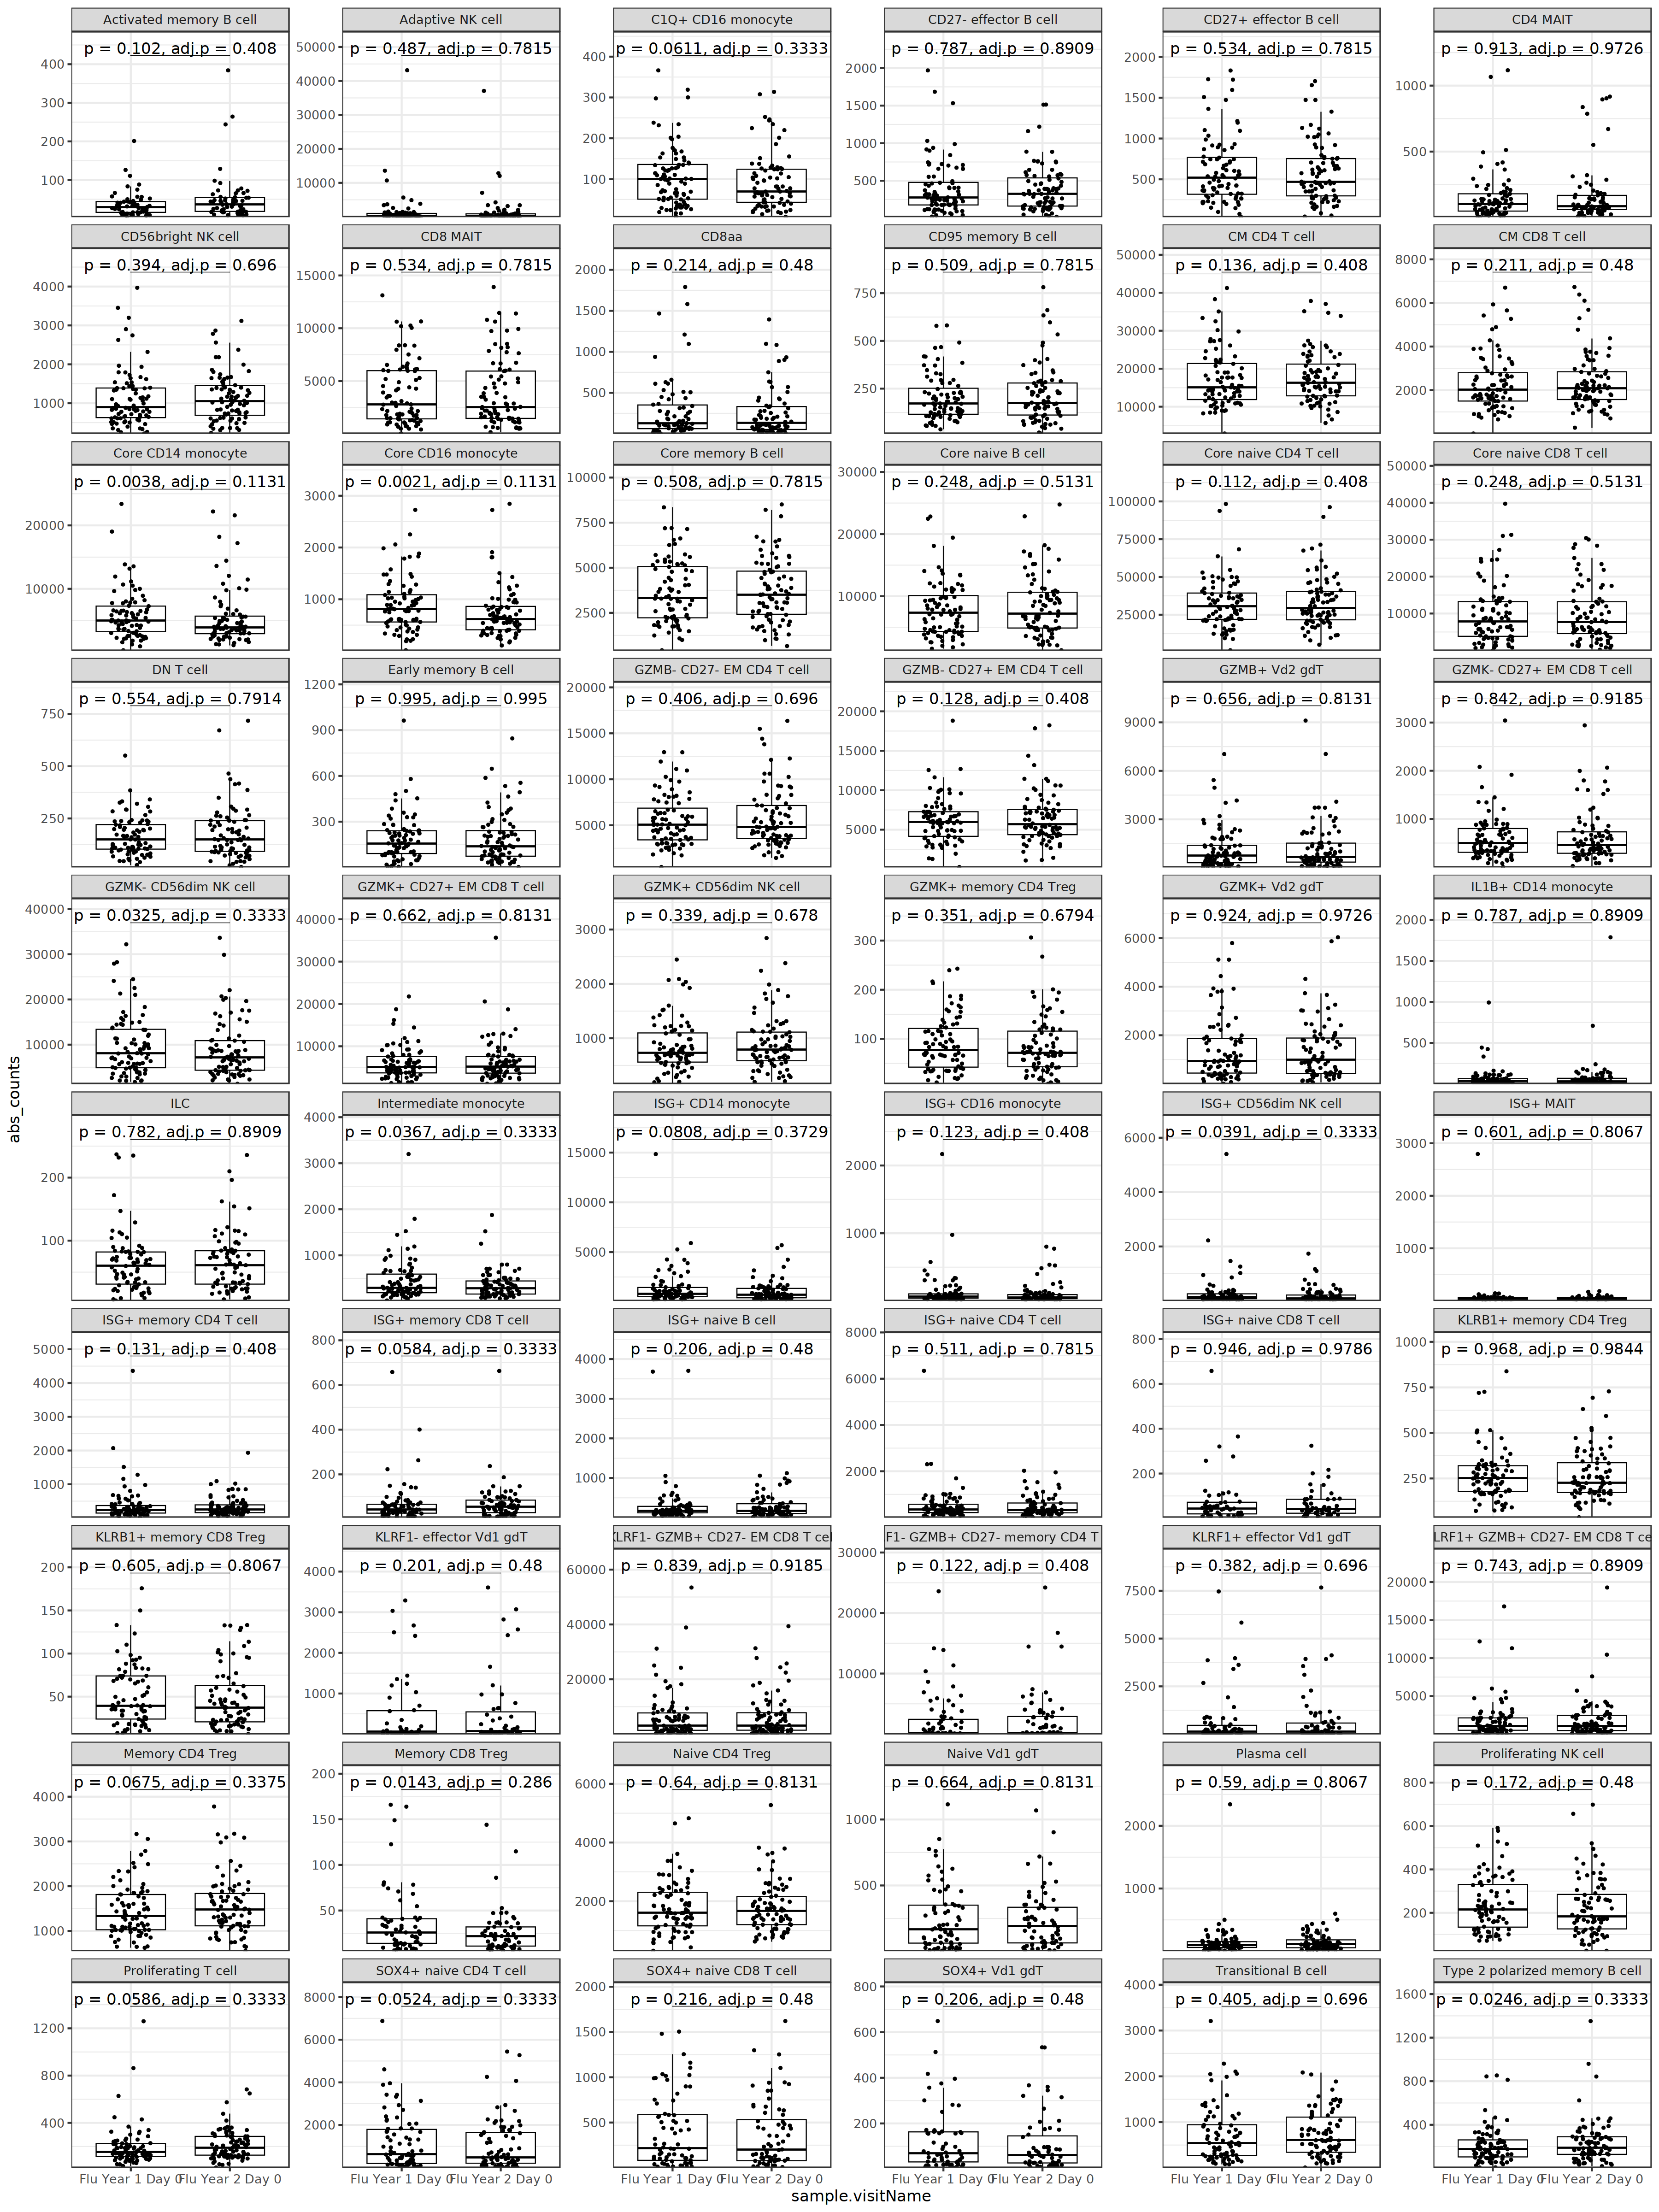

In [25]:
options(repr.plot.width = 30, repr.plot.height = 40)


ggboxplot(abs_counts_df , 
          x = "sample.visitName", 
          y = "abs_counts",
          palette = "jco",
          add = "jitter")+
facet_wrap(~AIFI_L3,
           scale='free_y',
           ncol=6)+   
stat_pvalue_manual(STAT_res, 
                   label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, 
                   y.position = 'max_y',
                   x.position=0.5,
                   size=7) +
theme_bw(base_size=20)+
scale_y_continuous(limits = c(NA, NA), 
                   expand = expansion(mult = c(0, 0.15)))